# Experiments with Model 2

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit
from uniform_encoders import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
# sns.set(context='paper', style='white', font='CMU Serif')
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':10, 'mathtext.fontset': 'cm'})

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = ScatteredHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # control signal to turn learning off
        self.applied_current = 0  # for experiments with external perturbation
    def get_CS(self, t):
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        return self.CS if applied else np.zeros((self.dim_CS))
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        applied = True if t%2>1.5 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning
    def get_applied_current(self, t):
        return self.applied_current

In [3]:
def build_network(
        dt = 0.001,
        nCond = 5,
        nExt = 10,
        seed = 0,
        nNeurons = 100,
        nNeuronsExtCS = 300,
        nNeuronsExtCTX = 500,
        dim_CS = 3,
        dim_CTX = 5,
        nCS = 1,
        nCTX = 3,
        intercept_CS = 0,
        intercept_CTX = 0,
        intercept_LA_pyr = -0.2,
        lr1 = 3e-5,
        lr2 = 3e-4,
        lr3 = 1e-5,
        T_BLA_CS=0.25,
        T_BLA_CTX=0.75,
    ):

    rng = np.random.RandomState(seed=seed)
    sampler = ScatteredHypersphere(surface=True)
    inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)
    encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
    intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
    encoders_CS = sampler.sample(nNeuronsExtCS, dim_CS, rng=rng)
    encoders_CTX = sampler.sample(nNeuronsExtCTX, dim_CTX, rng=rng)
    intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
    intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
    intercepts_pos = nengo.dists.Uniform(0,1)
    encoders_pos = nengo.dists.Choice([[1]])
    dInh = -3e0*np.ones((nNeurons, 1))

    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03

    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        bias = nengo.Node(lambda t: 0.5)
        stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
        applied_current = nengo.Node(lambda t, x: inputs.get_applied_current(t), size_in=2)
        # external ensembles
        external_CS = nengo.Ensemble(nNeuronsExtCS, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(nNeuronsExtCTX, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
        # amygdala ensembles
        LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
        LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
        CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        BLA_pyr = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        # error ensembles
        error_LA = nengo.Ensemble(nNeurons, 1)
        error_CeL = nengo.Ensemble(nNeurons, 1)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, LA_pyr[1])
        nengo.Connection(bias, CeL_off, transform=1)
        nengo.Connection(bias, CeM)
        nengo.Connection(CTX, external_CTX, synapse=None)
        # internal connections
        nengo.Connection(LA_pyr[1], LA_inh[1])
        nengo.Connection(CeL_on, CeL_off, transform=-1)
        nengo.Connection(CeL_off, CeM, transform=-1)
        nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
        nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
        nengo.Connection(BLA_pyr[0], CeM, transform=T_BLA_CS)  # CS response added to total fear response
        nengo.Connection(BLA_pyr[2], CeM, transform=T_BLA_CTX)  # CTX response added to total fear response
        # learned connections
        conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr1))
        transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr2))
        extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(lr3))
        # error connections
        nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
        nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
        nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
        nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
        nengo.Connection(BLA_pyr[2], error_BLA_safe)  # CTX response
        nengo.Connection(BLA_pyr[2], error_BLA_fear, transform=-1)  # -CTX response
        nengo.Connection(BLA_inh[0], error_BLA_safe)  # CS response
        nengo.Connection(BLA_inh[1], error_BLA_fear)  # US
        # error gating
        nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=0.3)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-x[1], transform=0.5*dInh)  # slow learning unless US
        # error updating
        nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
        nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-2)
        # stop learning during testing
        nengo.Connection(stop_learning, error_LA.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_BLA_safe.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_CeL.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_BLA_fear.neurons, transform=-1e3*np.ones((nNeurons, 1)))

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
        net.pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
        net.pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
        net.pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
        net.pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pLA_pyr = nengo.Probe(LA_pyr)
        net.pLA_inh = nengo.Probe(LA_inh)
        net.pCeL_on = nengo.Probe(CeL_on)
        net.pCeL_off = nengo.Probe(CeL_off)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        
        # save pointers
        net.inputs = inputs
        net.applied_current = applied_current
        net.LA_pyr = LA_pyr
        net.LA_inh = LA_inh
        net.CeL_on = CeL_on
        net.CeL_off = CeL_off
        net.CeM = CeM
        net.BLA_pyr = BLA_pyr
        net.BLA_inh = BLA_inh
        net.error_LA = error_LA
        net.error_CeL = error_CeL
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        
    return net

## Fear Expression and Neural Responses

In [4]:
def fear_expression_neural_responses(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        load=False,
        plot=False,
    ):

    if load:
        data_fear = pd.read_pickle(f"expression_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
        data_activity = pd.read_pickle(f"activity_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
        data_types = pd.read_pickle(f"types_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
    else:
        data_fear = pd.DataFrame(columns=["seed", "Fear Response", "Experiment"])
        data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
        data_types = pd.DataFrame(columns=["seed", "Type", "Percent"])
        rng = np.random.RandomState(seeds)

        for s in range(seeds):
            print(f"seed={s}")
            seed = s
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(seed=s, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            with sim:
                net.inputs.stop_learning = 0
                print("control")
                net.inputs.CS = net.inputs.CSs[0]
                net.inputs.CTX = net.inputs.CTXs[0]
                sim.run(2)
                T1a = int(1/dt)
                T1b = int(2/dt)
                print("conditioning")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 1
                for p in range(nCond):
                    sim.run(2)
                T2a = int((2+2*nCond-1)/dt)
                T2b = int((2+2*nCond-0.5)/dt)
                print("extinction")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                for p in range(nExt):
                    sim.run(2)
                T3a = int((2+2*nCond+2*nExt-1)/dt)
                T3b = int((2+2*nCond+2*nExt-0.5)/dt)
        #         print("turn learning off for testing")
                net.inputs.stop_learning = 1
                print("test CTX A")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 0
                sim.run(2)
                T4a = int((2+2*nCond+2*nExt+1)/dt)
                T4b = int((2+2*nCond+2*nExt+1.5)/dt)
                print("test CTX B")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                sim.run(2)
                T5a = int((2+2*nCond+2*nExt+2+1)/dt)
                T5b = int((2+2*nCond+2*nExt+2+1.5)/dt)  
                print("test CTX C")
                net.inputs.CTX = net.inputs.CTXs[2]
                net.inputs.US = 0
                sim.run(2)
                T6a = int((2+2*nCond+2*nExt+2+2+1)/dt)
                T6b = int((2+2*nCond+2*nExt+2+2+1.5)/dt)  

            if plot:
                ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
                ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
                ctxC_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[2])[0]
                ctx_signal = np.zeros((sim.trange().shape[0]))
                ctx_signal2 = np.zeros((sim.trange().shape[0]))
                ctx_signal[ctxB_idx] = 1
                ctx_signal2[ctxC_idx] = 0.5
                fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
                axes[0].plot(sim.trange(), sim.data[net.pCeM])
                axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
                axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
                axes[1].plot(sim.trange(), 1.8*sim.data[net.pUS], label="US", c='r')
                axes[1].plot(sim.trange(), ctx_signal)
                axes[1].plot(sim.trange(), ctx_signal2)
                axes[1].set(yticks=((0,0.5,1,1.4,1.8)), yticklabels=(("CTX+","CTXn","CTX-","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="BLA_pyr_US")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
                axes[2].legend()
                axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
                axes[3].plot(sim.trange(), sim.data[net.pError_LA], label="CS minus US")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX")
                axes[3].legend()
                axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
                plt.tight_layout()

            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]),
                "Experiment": "Control"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T4a: T4b]),
                "Experiment": "CTX+"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]),
                "Experiment": "CTX-"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T6a: T6b]),
                "Experiment": "CTX*"},
                ignore_index=True)

            aControl_LA_pyr = sim.data[net.pLA_pyr_spikes][T1a: T1b]
            aConditioning_LA_pyr = sim.data[net.pLA_pyr_spikes][T4a: T4b]
            aExtinction_LA_pyr = sim.data[net.pLA_pyr_spikes][T5a: T5b]
            aControl_CeL_on = sim.data[net.pCeL_on_spikes][T1a: T1b]
            aConditioning_CeL_on = sim.data[net.pCeL_on_spikes][T4a: T4b]
            aExtinction_CeL_on = sim.data[net.pCeL_on_spikes][T5a: T5b]
            aControl_CeL_off = sim.data[net.pCeL_off_spikes][T1a: T1b]
            aConditioning_CeL_off = sim.data[net.pCeL_off_spikes][T4a: T4b]
            aExtinction_CeL_off = sim.data[net.pCeL_off_spikes][T5a: T5b]
            aControl_BLA = sim.data[net.pBLA_pyr_spikes][T1a: T1b]
            aConditioning_BLA = sim.data[net.pBLA_pyr_spikes][T4a: T4b]
            aExtinction_BLA = sim.data[net.pBLA_pyr_spikes][T5a: T5b]    

            LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
            LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]
            fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
            fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
            fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
            extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
            persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aControl_CeL_on), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aConditioning_CeL_on), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aExtinction_CeL_on), "Experiment": "CTX-"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aControl_CeL_off), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aConditioning_CeL_off), "Experiment": "CTX+"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aExtinction_CeL_off), "Experiment": "CTX-"}, ignore_index=True)

            percent_up = len(LA_pyr_up)/(2*nNeurons)*100
            percent_down = len(LA_pyr_down)/(2*nNeurons)*100
            percent_fear = len(fear_neurons)/(4*nNeurons)*100
            percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
            percent_persistent = len(persistent_neurons)/(4*nNeurons)*100
            data_types = data_types.append({"seed": seed, "Type": "LA up", "Percent": percent_up}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "LA down", "Percent": percent_down}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "BLA Fear", "Percent": percent_fear}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "BLA Extinct", "Percent": percent_extinction}, ignore_index=True)
            data_types = data_types.append({"seed": seed, "Type": "BLA Persist", "Percent": percent_persistent}, ignore_index=True)

        data_fear.to_pickle(f"expression_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
        data_activity.to_pickle(f"activity_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
        data_types.to_pickle(f"types_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")

    emp_fear = pd.DataFrame(columns=["Fear Response", "Experiment"])
    emp_fear = emp_fear.append({"Fear Response": (0.5-0.4)/6, "Experiment": "Control"}, ignore_index=True)    
    emp_fear = emp_fear.append({"Fear Response": (5.6-0.5)/6, "Experiment": "Acquisition"}, ignore_index=True)    
    emp_fear = emp_fear.append({"Fear Response": (1.5-0.2)/6, "Experiment": "Extinction"}, ignore_index=True)    
    emp_fear = emp_fear.append({"Fear Response": (5.6-3.2)/6, "Experiment": "Reinstatement"}, ignore_index=True)     
  
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((6.38, 2)), sharey=True)   
    sns.barplot(data=emp_fear, x='Experiment', y="Fear Response", palette=palette, ax=axes[0])
    sns.barplot(data=data_fear, x='Experiment', y="Fear Response", palette=palette, ax=axes[1])
    axes[0].set(xlabel=None, xticklabels=["Control", "Acquisition", "Extinction", "Reinstate"], yticks=((0, 0.25, 0.5, 0.75, 1.0)))
    axes[1].set(xlabel=None, xticklabels=["Control", r"CTX$^+$", r"CTX$^-$", r"CTX$^*$"], ylabel=None, yticks=(()))
    plt.tight_layout()
    fig.savefig(f"expression_dimCS={dim_CS}_dimCTX={dim_CTX}.svg")
    fig.savefig(f"expression_dimCS={dim_CS}_dimCTX={dim_CTX}.png", dpi=600)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((6.38, 2)))
    sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
    ax.set(xlabel=None, ylabel="Mean Firing Rate (Hz)", yticks=((0,100,200,300)))
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.savefig(f"activity_dimCS={dim_CS}_dimCTX={dim_CTX}.svg")
    fig.savefig(f"activity_dimCS={dim_CS}_dimCTX={dim_CTX}.png", dpi=600)
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=((6.38,2)), sharey=True)
    sns.histplot(data=data_types.query("Type=='LA up'")['Percent'], stat="percent", bins=10, ax=axes[0])
    sns.histplot(data=data_types.query("Type=='LA down'")['Percent'], stat="percent", bins=10, ax=axes[1])
    sns.histplot(data=data_types.query("Type=='BLA Fear'")['Percent'], stat="percent", bins=10, ax=axes[2])
    sns.histplot(data=data_types.query("Type=='BLA Persist'")['Percent'], stat="percent", bins=10, ax=axes[3])
    sns.histplot(data=data_types.query("Type=='BLA Extinct'")['Percent'], stat="percent", bins=10, ax=axes[4])
    axes[0].set(title="LA Up", ylabel="Frequency\nacross networks", xticks=((20,27,34)))
    axes[1].set(title="LA Down", xticks=((33,36,39)))
    axes[2].set(title="BLA Fear", xticks=((4,6,8)))
    axes[3].set(title="BLA Persist", xticks=((25,30,35)))
    axes[4].set(title="BLA Extinct", xticks=((5,10,15)))
    plt.tight_layout()
    fig.savefig(f"types_dimCS={dim_CS}_dimCTX={dim_CTX}.svg")
    fig.savefig(f"types_dimCS={dim_CS}_dimCTX={dim_CTX}.png", dpi=600)


seed=0


c:\users\peter duggins\.virtualenvs\amygdala-upz-rez2\lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=1
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=2
control
conditioning
extinction
test CTX A
test CTX B
test CTX C


findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


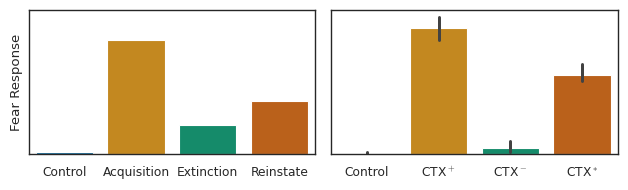

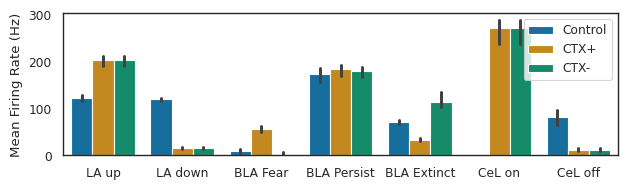

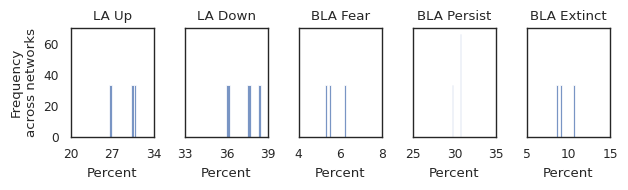

In [10]:
fear_expression_neural_responses(seeds=3, plot=False, load=False)

## Activation and Inactivation

In [67]:
def activation_inactivation(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        T_current=2,
        target="LA_pyr",
        stims=["Inactivate", "None", "Activate"],
        blocks=[
            "Control",
            "Acquisition",
            "Extinction",
            "CTX+",
            "CTX-"],
        load=False,
        plot=False,
    ):

    if load:
        data = pd.read_pickle(f"activation_{target}_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")    
    else:
        data = pd.DataFrame(columns=["seed", "Fear Response", "Stimulus", "Block", "Test"])
        rng = np.random.RandomState(seeds)

        for seed in range(seeds):
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            for stim in stims:
                for block in blocks:
                    print(f"seed={seed}, target={target}, block={block}, stim={stim}")
                    net = build_network(seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                        dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
                    with net:
                        if target=="LA_pyr":
                            nengo.Connection(net.applied_current, net.LA_pyr.neurons, transform=np.ones((2*nNeurons, 1)))
                        if target=="LA_inh":
                            nengo.Connection(net.applied_current, net.LA_inh.neurons, transform=np.ones((2*nNeurons, 1)))
                        if target=="BLA_pyr":
                            nengo.Connection(net.applied_current, net.BLA_pyr.neurons, transform=np.ones((3*nNeurons, 1)))
                        if target=="BLA_inh":
                            nengo.Connection(net.applied_current, net.BLA_inh.neurons, transform=np.ones((2*nNeurons, 1)))
                        if target=="CeL":
                            nengo.Connection(net.applied_current, net.CeL_on.neurons, transform=np.ones((nNeurons, 1)))
                            nengo.Connection(net.applied_current, net.CeL_off.neurons, transform=np.ones((nNeurons, 1)))
                        if target=="CeM":
                            nengo.Connection(net.applied_current, net.CeM.neurons, transform=np.ones((nNeurons, 1)))
                        net.pApplied = nengo.Probe(net.applied_current)
                    sim = nengo.Simulator(net, dt=dt, progress_bar=False)
                    with sim:
                        net.inputs.stop_learning = 0
                        print("control")
                        net.inputs.CS = net.inputs.CSs[0]
                        net.inputs.CTX = net.inputs.CTXs[0]
                        if block=="Control" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="Control" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        sim.run(2)
                        T1a = int(1/dt)
                        T1b = int(2/dt)
                        print("conditioning")
                        net.inputs.CTX = net.inputs.CTXs[0]
                        net.inputs.US = 1
                        if block=="Acquisition" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="Acquisition" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        for p in range(nCond):
                            sim.run(2)
                        T2a = int((2+2*nCond-1)/dt)
                        T2b = int((2+2*nCond-0.5)/dt)
                        print("extinction")
                        net.inputs.CTX = net.inputs.CTXs[1]
                        net.inputs.US = 0
                        if block=="Extinction" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="Extinction" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        for p in range(nExt):
                            sim.run(2)
                        T3a = int((2+2*nCond+2*nExt-1)/dt)
                        T3b = int((2+2*nCond+2*nExt-0.5)/dt)
                        net.inputs.stop_learning = 1
                        print("test CTX A")
                        if block=="CTX+" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="CTX+" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        net.inputs.CTX = net.inputs.CTXs[0]
                        net.inputs.US = 0
                        sim.run(2)
                        T4a = int((2+2*nCond+2*nExt+1)/dt)
                        T4b = int((2+2*nCond+2*nExt+1.5)/dt)
                        print("test CTX B")
                        if block=="CTX-" and stim=="Activate":
                            net.inputs.applied_current = T_current
                        elif block=="CTX-" and stim=="Inactivate":
                            net.inputs.applied_current = -T_current
                        else:
                            net.inputs.applied_current = 0
                        net.inputs.CTX = net.inputs.CTXs[1]
                        net.inputs.US = 0
                        sim.run(2)
                        T5a = int((2+2*nCond+2*nExt+2+1)/dt)
                        T5b = int((2+2*nCond+2*nExt+2+1.5)/dt)

                    if plot:
                        ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
                        ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
                        ctxC_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[2])[0]
                        ctx_signal = np.zeros((sim.trange().shape[0]))
                        ctx_signal2 = np.zeros((sim.trange().shape[0]))
                        ctx_signal[ctxB_idx] = 1
                        ctx_signal2[ctxC_idx] = 0.5
                        fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
                        axes[0].plot(sim.trange(), sim.data[net.pCeM])
                        axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
                        axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
                        axes[1].plot(sim.trange(), 1.8*sim.data[net.pUS], label="US", c='r')
                        axes[1].plot(sim.trange(), ctx_signal)
                        axes[1].plot(sim.trange(), ctx_signal2)
                        axes[1].set(yticks=((0,0.5,1,1.4,1.8)), yticklabels=(("CTX+","CTXn","CTX-","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
                        axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
                        axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="BLA_pyr_US")
                        axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
                        axes[2].legend()
                        axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
                        axes[3].plot(sim.trange(), sim.data[net.pApplied], label="applied current")
                        axes[3].plot(sim.trange(), sim.data[net.pError_LA], label="CS minus US")
                        axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX")
                        axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX")
                        axes[3].legend()
                        axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
                        plt.tight_layout()
                    
                    data = data.append({"seed": seed, "Test" :"Baseline", "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]), "Stimulus": stim, "Block": block},ignore_index=True)
                    data = data.append({"seed": seed, "Test" :"CTX+", "Fear Response": np.mean(sim.data[net.pCeM][T4a: T4b]), "Stimulus": stim, "Block": block}, ignore_index=True)
                    data = data.append({"seed": seed, "Test" :"CTX-", "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]), "Stimulus": stim, "Block": block}, ignore_index=True)
                    
        data.to_pickle(f"activation_{target}_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")

In [68]:
activation_inactivation(seeds=10, stims=["None", "Inactivate"], target="LA_pyr")

seed=0, target=LA_pyr, block=Control, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Acquisition, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Extinction, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=CTX+, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=CTX-, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_pyr, block=CTX-, stim=Inactivate
co

test CTX B
seed=7, target=LA_pyr, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=7, target=LA_pyr, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Control, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Acquisition, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Extinction, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=CTX+, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=CTX-, stim=None
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=8, target=LA_pyr, block=Extinction, stim=In

In [69]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="LA_inh")

seed=0, target=LA_inh, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_inh, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_inh, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_inh, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=LA_inh, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=LA_inh, 

In [70]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="BLA_pyr")

seed=0, target=BLA_pyr, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_pyr, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_pyr, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_pyr, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_pyr, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_pyr, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_pyr, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_pyr, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_pyr, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target

In [71]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="BLA_inh")

seed=0, target=BLA_inh, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_inh, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_inh, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_inh, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=BLA_inh, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_inh, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_inh, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_inh, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=BLA_inh, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target

In [72]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="CeL")

seed=0, target=CeL, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeL, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeL, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeL, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeL, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeL, block=CTX-, stim=Inactivate
co

In [73]:
activation_inactivation(seeds=10, stims=["Inactivate"], target="CeM")

seed=0, target=CeM, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeM, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeM, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeM, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=0, target=CeM, block=CTX-, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=Control, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=Acquisition, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=Extinction, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=CTX+, stim=Inactivate
control
conditioning
extinction
test CTX A
test CTX B
seed=1, target=CeM, block=CTX-, stim=Inactivate
co

### replot inactivaiton data

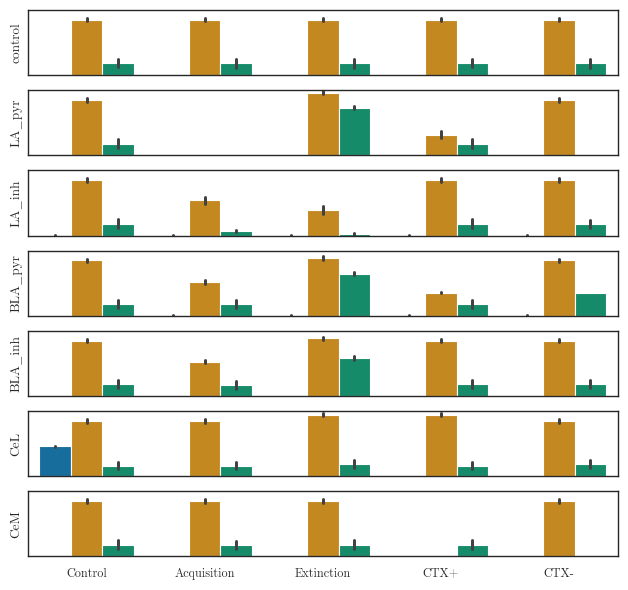

In [77]:
dim_CS = 3
dim_CTX = 5
targets = ["LA_pyr", "LA_inh", "BLA_pyr", "BLA_inh", "CeL", "CeM"]
fig, axes = plt.subplots(nrows=len(targets)+1, ncols=1, sharex=True, figsize=((6.38, 6)))

data = pd.read_pickle(f"activation_LA_pyr_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl").query("Stimulus=='None'")
sns.barplot(data=data, x='Block', y='Fear Response', hue="Test", ax=axes[0], palette=palette)
axes[0].set(ylabel="control", yticks=(()), ylim=((0, 1.1)), xlabel=None)
axes[0].get_legend().remove()

for i, target in enumerate(targets):
    data = pd.read_pickle(f"activation_{target}_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl").query("Stimulus=='Inactivate'")
    sns.barplot(data=data, x='Block', y='Fear Response', hue="Test", ax=axes[i+1], palette=palette)
    axes[i+1].set(ylabel=target, yticks=(()), ylim=((0, 1.1)), xlabel=None)
    axes[i+1].get_legend().remove()

plt.tight_layout()
# fig.savefig(f"inactivation_combined.png", dpi=600)
fig.savefig(f"inactivation_dimCS={dim_CS}_dimCTX={dim_CTX}.svg")

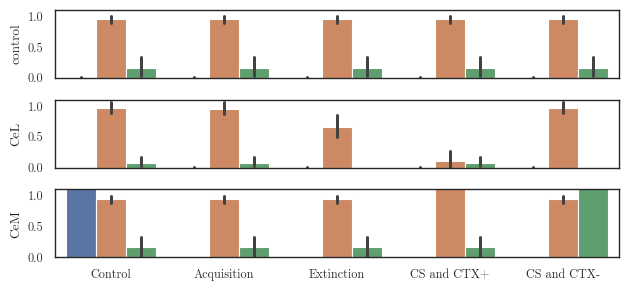

In [129]:
dim_CS = 3
dim_CTX = 5
targets = ["CeL", "CeM"]
fig, axes = plt.subplots(nrows=len(targets)+1, ncols=1, sharex=True, figsize=((6.38, 3)))

data = pd.read_pickle(f"activation_LA_pyr_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl").query("Stimulus=='None'")
sns.barplot(data=data, x='Block', y='Fear Response', hue="Test", ax=axes[0])
axes[0].set(ylabel="control", yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel=None)
axes[0].get_legend().remove()

for i, target in enumerate(targets):
    data = pd.read_pickle(f"activation_{target}_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl").query("Stimulus=='Activate'")
    sns.barplot(data=data, x='Block', y='Fear Response', hue="Test", ax=axes[i+1])
    axes[i+1].set(ylabel=target, yticks=((0, 0.5, 1.0)), ylim=((0, 1.1)), xlabel=None)
    axes[i+1].get_legend().remove()

plt.tight_layout()
fig.savefig(f"activation_dimCS={dim_CS}_dimCTX={dim_CTX}.png", dpi=600)
fig.savefig(f"activation_dimCS={dim_CS}_dimCTX={dim_CTX}.svg")

## Fear Generalization

In [8]:
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

In [118]:
def genCS(
        seeds=1,
        nNeurons=100,
        nNeuronsExtCS=300,
        nNeuronsExtCTX=500,
        dt=1e-3,
        nCond=10,
        nCS=2,
        nCTX=1,
        dim_CS=3,
        dim_CTX=5,
        intercept_CS=0,
        intercept_CTX=0,
        load=False,
        choose_intercepts_method='fixed',
        sparsity=0.5,
    ):

    if load:
        data = pd.read_pickle(f"genCS_intercept{intercept_CS}_dimCS={dim_CS}_dimCTX={dim_CTC}.pkl")
    else:
        rng = np.random.RandomState(seeds)
        data = pd.DataFrame(columns=["seed", "Fear Response", "Similarity to CS+"])
        for seed in range(seeds):
            print(f"seed={seed}")
            lr1 = rng.uniform(1e-4, 3e-4)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(2e-5, 5e-5)
#             lr1 = rng.uniform(2e-5, 4e-5)
#             lr2 = rng.uniform(2e-4, 6e-4)
#             lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            if choose_intercepts_method=='fixed':
                intCS = intercept_CS
                intCTX = intercept_CTX
            elif choose_intercepts_method=='sparsity':
                intCS = sparsity_to_x_intercept(dim_CS, sparsity)
#                 print(f"sparsity {sparsity}, dimension {dim_CS} => intercept {intCS}")
                intCTX = intercept_CTX
#                 intCTX = sparsity_to_x_intercept(dim_CTX, sparsity)                
            net = build_network(
                seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                intercept_CS=intCS, intercept_CTX=intCTX,
                dt=dt, nNeurons=nNeurons, nNeuronsExtCS=nNeuronsExtCS, nNeuronsExtCTX=nNeuronsExtCTX,
                nCond=nCond, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=10000)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            CTX = net.inputs.CTXs[0]
            CSplus = net.inputs.CSs[0]
            similarities = np.dot(CSplus, net.inputs.CSs.T)
            CSminus = net.inputs.CSs[np.argmin(np.abs(similarities))]            
            target_similarities = np.linspace(0, 1, nCS)
            stims = np.array([CSplus for n in range(nCond)] + [CSminus for n in range(nCond)])
            rng.shuffle(stims)
            with sim:
                print("acquisition")
                net.inputs.stop_learning = 0
                net.inputs.CTX = CTX
                for p in range(len(stims)):
#                     print(f"pair {p}")
                    net.inputs.CS = stims[p]
                    net.inputs.US = 1 if np.all(stims[p]==CSplus) else 0
                    sim.run(2)
                print("testing")
                net.inputs.stop_learning = 1
                net.inputs.US = 0
                for cs in range(nCS):
                    target_sim = target_similarities[cs]
                    CS = net.inputs.CSs[np.argmin(np.abs(similarities-target_sim))]
                    net.inputs.CS = CS
#                     print(f"CS* #{cs}, similarity={np.dot(CSplus, CS):.2}")
                    sim.run(2)
                    freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                    similarity = np.dot(CSplus, CS)
                    data = data.append({
                        "seed": int(seed),
                        "Fear Response": freezing,
                        "Similarity to CS+": np.around(similarity, 3),
                    }, ignore_index=True)

    if choose_intercepts_method=='fixed':
        data.to_pickle(f"genCS_intercept{intCS}_dimCS={dim_CS}.pkl")
    elif choose_intercepts_method=='sparsity':
        data.to_pickle(f"genCS_sparsity{sparsity}_dimCS={dim_CS}.pkl")

### CS Generalization Plotting

In [125]:
def plot_genCS(sparsities, dim_CS, dim_CTX, xmin=-1, ymin=0.5, ymax=1.0):

    xs = [2.0, 2.45, 3.05, 3.65, 4.25, 4.7]
    xITI = [1.5]
    ys_control = [0.06, 0.12, 0.21, 0.58, 1.07, 1.61]
    yITI_control = [0.04]
    ys_GAD = [0.44, 0.56, 0.72, 1.07, 1.51, 1.68]
    yITI_GAD = [0.70]
    
    def sigmoid(x, L ,x0, k, b):
        y = L / (1 + np.exp(-k*(x-x0))) + b
        return (y)

    p0_control = [max(ys_control), np.median(xs),1,min(ys_control)] # this is an mandatory initial guess
    p0_GAD = [max(ys_GAD), np.median(xs),1,min(ys_GAD)] # this is an mandatory initial guess
    popt_control, pcov_control = curve_fit(sigmoid, xs, ys_control, p0_control, method='dogbox')
    popt_GAD, pcov_GAD = curve_fit(sigmoid, xs, ys_GAD, p0_GAD, method='dogbox')
    xs2 = np.linspace(min(xs), max(xs), 1000)
    yfit_control = sigmoid(xs2, *popt_control)
    yfit_GAD = sigmoid(xs2, *popt_GAD)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((6.38, 3)))
    sns.scatterplot(x=xs, y=ys_control, ax=axes[0], s=50, label="Control")
#     sns.scatterplot(x=xITI, y=yITI_control, ax=axes[0], s=50, color=palette[0], label=None, marker='s')
    sns.lineplot(x=xs2, y=yfit_control, ax=axes[0], label=None, color=palette[0])
    axes[0].set(xlabel="Test Stimulus", ylabel="Risk Ratings",
          ylim=((-0.1, 1.8)), yticks=((0, 0.4, 0.8, 1.2, 1.6)), xticks=(()))
    sns.scatterplot(x=xs, y=ys_GAD, ax=axes[0], s=50, label="GAD")
#     sns.scatterplot(x=xITI, y=yITI_GAD, ax=axes[0], s=50, color=palette[1], label=None, marker='s')
    sns.lineplot(x=xs2, y=yfit_GAD, ax=axes[0], label=None, color=palette[1])
    xtickExtra = [r"CS$^-$", r"CS$^1$", r"CS$^2$", r"CS$^3$", r"CS$^4$", r"CS$^+$"]
#     xticklabels = ['ITI'] + [xtickExtra[i] for i in range(len(xs))]
    xticklabels = [xtickExtra[i] for i in range(len(xs))]
    axes[0].set(ylabel="Fear Response", xlabel="Test Stimulus", title="Empirical Data",
          ylim=((-0.1, 1.8)), yticks=((0, 0.4, 0.8, 1.2, 1.6)), xticks=xs, xticklabels=xticklabels) #xITI+
    axes[0].legend(title="Experimental Group")

    for i, sparsity in enumerate(sparsities):
        data = pd.read_pickle(f"genCS_sparsity{sparsity}_dimCS={dim_CS}.pkl")
        X = data.query("seed==0")['Similarity to CS+'].to_numpy()
        nCS = len(X)
        Y = data['Fear Response'].to_numpy().reshape(-1, nCS).T
        xbin = int((nCS-2)/4)
        xsim = [X[0], np.mean(X[1:xbin+1]), np.mean(X[xbin+1: 2*xbin+1]), np.mean(X[2*xbin+1: 3*xbin+1]), np.mean(X[3*xbin+1: 4*xbin+1]), X[-1]]
        ysim = [np.mean(Y[0]), np.mean(Y[1:xbin+1]), np.mean(Y[xbin+1: 2*xbin+1]), np.mean(Y[2*xbin+1: 3*xbin+1]), np.mean(Y[3*xbin+1: 4*xbin+1]), np.mean(Y[-1])]
        if sparsity==min(sparsities): label="Strong"
        if sparsity==max(sparsities): label="Weak"
        sns.scatterplot(xsim, ysim, ax=axes[1], color=palette[i], s=50, label=label, zorder=2)
        sns.lineplot(data=data, x='Similarity to CS+', y="Fear Response",
            ax=axes[1], color=palette[i])

    axes[0].set(xlabel=None)
    axes[1].set(xticks=xsim, xlim=((-0.1, 1.1)),
#         xlabel=r'Similarity of CS$^*$ to CS$^+$',
        xticklabels=xticklabels, xlabel=None,
        title="Model Data", ylabel=None, yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2)), ylim=((ymin, ymax)))
    axes[1].legend(title="Pattern Separation", loc="upper left")

    plt.tight_layout()
    fig.savefig(f"genCS_dimCS={dim_CS}.svg")
    fig.savefig(f"genCS_dimCS={dim_CS}.png", dpi=600)

In [ ]:
sparsities = [0.1, 0.2]
seeds = 10
nCS = 22
dim_CS = 3
dim_CTX = 5
nNeuronsExtCS = 10000
for i in sparsities:
    print(f"sparsity {i}")
    genCS(seeds=seeds, nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, nNeuronsExtCS=nNeuronsExtCS,
          sparsity=i, choose_intercepts_method='sparsity')
plot_genCS(sparsities, dim_CS, dim_CTX, xmin=0.0, ymin=0.3, ymax=1.1)

sparsity 0.1
seed=0


/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/nengo/cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


acquisition
testing
seed=1
acquisition
testing
sparsity 0.17
seed=0
acquisition
testing
seed=1
acquisition
testing


/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


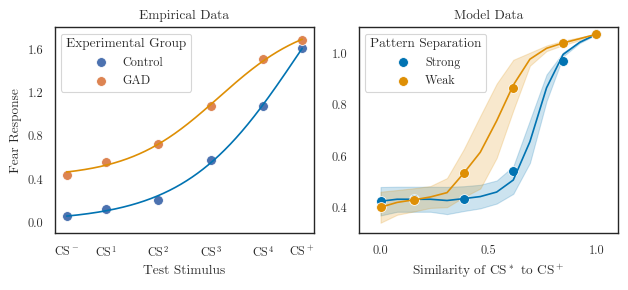

In [119]:
sparsities = [0.1, 0.17]
seeds = 2
nCS = 14
dim_CS = 3
dim_CTX = 5
nNeuronsExtCS = 10000
for i in sparsities:
    print(f"sparsity {i}")
    genCS(seeds=seeds, nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, nNeuronsExtCS=nNeuronsExtCS,
          sparsity=i, choose_intercepts_method='sparsity')
plot_genCS(sparsities, dim_CS, dim_CTX, xmin=0.0, ymin=0.3, ymax=1.1)

/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


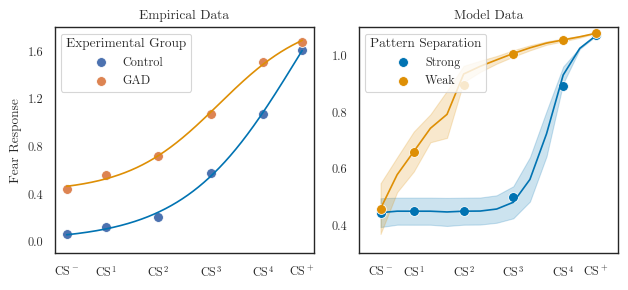

In [126]:
sparsities = [0.08, 0.22]
seeds = 2
nCS = 14
dim_CS = 3
dim_CTX = 5
nNeuronsExtCS = 10000
# for i in sparsities:
#     print(f"sparsity {i}")
#     genCS(seeds=seeds, nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, nNeuronsExtCS=nNeuronsExtCS,
#           sparsity=i, choose_intercepts_method='sparsity')
plot_genCS(sparsities, dim_CS, dim_CTX, xmin=0.0, ymin=0.3, ymax=1.1)

In [105]:
sparsities = [0.1, 0.3]
seeds = 3
nCS = 20
dim_CS = 3
dim_CTX = 5
nNeuronsExtCS = 10000
for i in sparsities:
    print(f"sparsity {i}")
    genCS(seeds=seeds, nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, nNeuronsExtCS=nNeuronsExtCS,
          sparsity=i, choose_intercepts_method='sparsity')
plot_genCS(sparsities, dim_CS, dim_CTX, xmin=-1.0, ymin=0.3, ymax=1.1)

sparsity 0.1
seed=0


/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/nengo/cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


KeyboardInterrupt: 

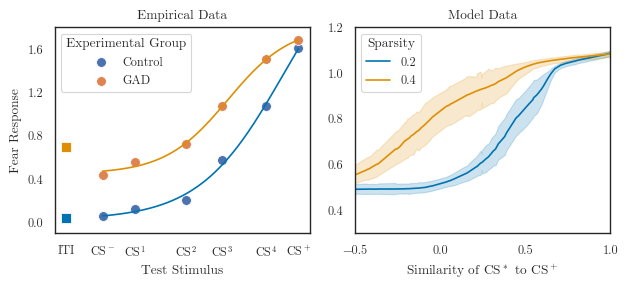

In [133]:
sparsities = [0.2, 0.4]
seeds = 10
nCS = 100
dim_CS = 3
dim_CTX = 5
nNeuronsExtCS = 10000
# for i in sparsities:
#     print(f"sparsity {i}")
#     genCS(seeds=seeds, nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, nNeuronsExtCS=nNeuronsExtCS,
#           sparsity=i, choose_intercepts_method='sparsity')
plot_genCS(sparsities, dim_CS, dim_CTX, xmin=-0.5, ymin=0.3, ymax=1.2)

## Scale to higher dimensions

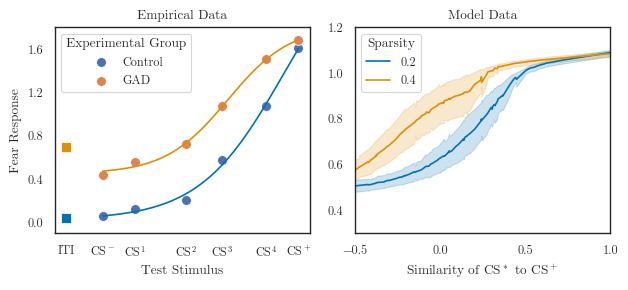

In [134]:
sparsities = [0.2, 0.4]
seeds = 10
nCS = 100
dim_CS = 7
dim_CTX = 5
nNeuronsExtCS = 10000
# for i in sparsities:
#     print(f"sparsity {i}")
#     genCS(seeds=seeds, nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, nNeuronsExtCS=nNeuronsExtCS,
#           sparsity=i, choose_intercepts_method='sparsity')
plot_genCS(sparsities, dim_CS, dim_CTX, xmin=-0.5, ymin=0.3, ymax=1.2)

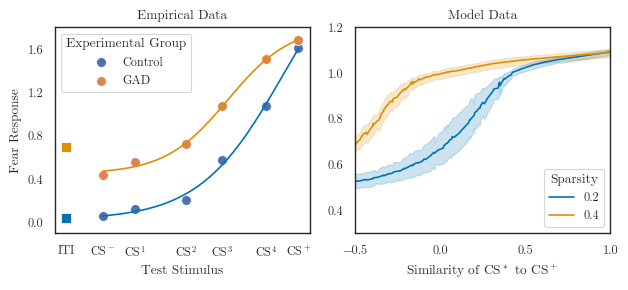

In [135]:
sparsities = [0.2, 0.4]
seeds = 10
nCS = 100
dim_CS = 11
dim_CTX = 5
nNeuronsExtCS = 10000
# for i in sparsities:
#     print(f"sparsity {i}")
#     genCS(seeds=seeds, nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, nNeuronsExtCS=nNeuronsExtCS,
#           sparsity=i, choose_intercepts_method='sparsity')
plot_genCS(sparsities, dim_CS, dim_CTX, xmin=-0.5, ymin=0.3, ymax=1.2)

### plot it

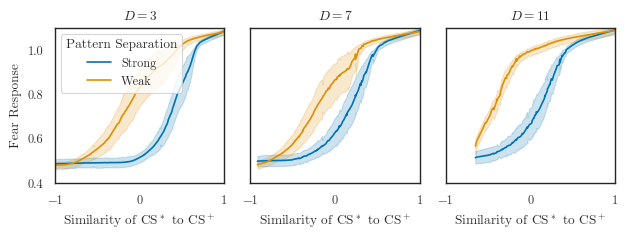

In [139]:
xmin = -1.0
ymin = 0.4
ymax = 1.1
dimensions = [3,7,11]
sparsities = [0.2, 0.4]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((6.38, 2.5)), sharey=True)
for j, dim_CS in enumerate(dimensions):
    for i, sparsity in enumerate(sparsities):
        data = pd.read_pickle(f"genCS_sparsity{sparsity}_dimCS={dim_CS}.pkl")
        if sparsity==min(sparsities): label="Strong"
        elif sparsity==max(sparsities): label="Weak"
#         label = sparsity
        sns.lineplot(data=data, x='Similarity to CS+', y="Fear Response",
            ax=axes[j], color=palette[i], label=label)
        axes[j].set(xticks=((-1.0, 0.0, 1.0)), xlim=((xmin, 1.0)), xlabel=r'Similarity of CS$^*$ to CS$^+$',
            title=r"$D=$"+str(dim_CS), ylabel="Fear Response",
            yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2)), ylim=((ymin, ymax)))

axes[0].legend(title="Pattern Separation")
axes[1].get_legend().remove()
axes[2].get_legend().remove()
plt.tight_layout()
fig.savefig(f"dimensions.svg")
fig.savefig(f"dimensions.png", dpi=600)

### CTX Generalization

In [ ]:
def generalization(
        experiment,
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        nCS=1,
        nCTX=2,
        dim_CS=3,
        dim_CTX=5,
        intercept_CS=0,
        intercept_CTX=0,
        load=False,
        style="line",
    ):

    if load:
        if experiment=="CS":
            data = pd.read_pickle(f"generalization_{experiment}_intercept{intercept_CS}_dimCS={dim_CS}_dimCTX={dim_CTC}.pkl")
        if experiment=="CTX":
            data = pd.read_pickle(f"generalization_{experiment}_intercept{intercept_CTX}_dimCS={dim_CS}_dimCTX={dim_CTC}.pkl")
        if experiment=="CS+CTX":
            data = pd.read_pickle(f"generalization_{experiment}_intercept{intercept_CTX}_dimCS={dim_CS}_dimCTX={dim_CTC}.pkl")

    else:
        rng = np.random.RandomState(seeds)
        if experiment=="CS":
            data = pd.DataFrame(columns=["seed", "Fear Response", "Similarity to CS+"])
        elif experiment=="CTX" or experiment=="CS+CTX":
            data = pd.DataFrame(columns=["seed", "Fear Response", "Similarity to CTX+", "Similarity to CTX-"])
        for seed in range(seeds):
            print(f"seed={seed}")
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(
                seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                intercept_CS=intercept_CS, intercept_CTX=intercept_CTX,
                dt=dt, nNeurons=nNeurons,
                nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            CTXplus = net.inputs.CTXs[0]
            CSplus = net.inputs.CSs[0]
            CTXsim = np.dot(CTXplus, net.inputs.CTXs.T)
            CTXminus = net.inputs.CTXs[np.argmin(CTXsim)]
            with sim:
                print("acquisition")
                net.inputs.stop_learning = 0
                net.inputs.US = 1
                net.inputs.CS = CSplus
                net.inputs.CTX = CTXplus
                for p in range(nCond):
                    sim.run(2)
                print("extinction")
                net.inputs.CS = 0
                net.inputs.US = 0
                net.inputs.CTX = CTXminus
                for p in range(nExt):
                    sim.run(2)
                print("testing")
                net.inputs.stop_learning = 1
                net.inputs.US = 0
                if experiment=="CS":
                    for cs in range(nCS):
                        print(f"CS {cs}")
                        CS = net.inputs.CSs[cs]
                        net.inputs.CS = CS
                        net.inputs.CTX = CTXplus
                        sim.run(2)
                        freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                        similarity = np.dot(CSplus, CS)
                        data = data.append({
                            "seed": int(seed),
                            "Fear Response": freezing,
                            "Similarity to CS+": np.around(similarity, 3),
                        }, ignore_index=True)
                elif experiment=="CTX":
                    for ctx in range(nCTX):
                        print(f"CTX {ctx}")
                        CTX = net.inputs.CTXs[ctx]
                        net.inputs.CTX = CTX
                        net.inputs.CS = 0
                        net.inputs.US = 0
                        sim.run(2)
                        freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                        similarity_plus = np.dot(CTXplus, CTX)
                        similarity_minus = np.dot(CTXminus, CTX)
                        data = data.append({
                            "seed": int(seed),
                            "Fear Response": freezing,
                            "Similarity to CTX+": np.around(similarity_plus, 3),
                            "Similarity to CTX-": np.around(similarity_minus, 3),
                        }, ignore_index=True)
                elif experiment=="CS+CTX":
                    for ctx in range(nCTX):
                        print(f"CTX {ctx}")
                        CTX = net.inputs.CTXs[ctx]
                        net.inputs.CTX = CTX
                        net.inputs.CS = CSplus
                        net.inputs.US = 0
                        sim.run(2)
                        freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                        similarity_plus = np.dot(CTXplus, CTX)
                        similarity_minus = np.dot(CTXminus, CTX)
                        data = data.append({
                            "seed": int(seed),
                            "Fear Response": freezing,
                            "Similarity to CTX+": np.around(similarity_plus, 3),
                            "Similarity to CTX-": np.around(similarity_minus, 3),
                        }, ignore_index=True)

    if experiment=="CS":
        data.to_pickle(f"generalization_{experiment}_intercept{intercept_CS}_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
    if experiment=="CTX":
        data.to_pickle(f"generalization_{experiment}_intercept{intercept_CTX}_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
    if experiment=="CS+CTX":
        data.to_pickle(f"generalization_{experiment}_intercept{intercept_CTX}_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")

In [31]:
intercepts = [0.5, 0.0]
seeds = 2
nCTX = 5
dim_CS = 3
dim_CTX = 5
for i in intercepts:
    generalization(experiment="CS+CTX", seeds=seeds, nCTX=nCTX, intercept_CTX=i, dim_CS=dim_CS, dim_CTX=dim_CTX, load=False)

seed=0


c:\users\peter duggins\.virtualenvs\amygdala-upz-rez2\lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
seed=1
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
seed=0
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
seed=1
acquisition
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4


### Plot

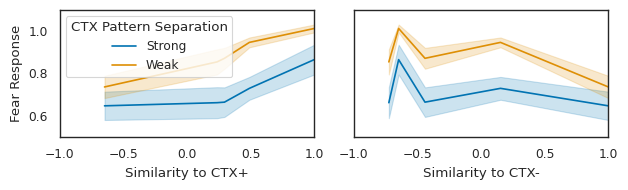

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((6.38, 2)))

for i, intercept in enumerate(intercepts):
    data = pd.read_pickle(f"generalization_CS+CTX_intercept{intercept}_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
    if intercept==0.0: label="Weak"
    if intercept==0.5: label="Strong"
    sns.lineplot(data=data, x='Similarity to CTX+', y="Fear Response",
        ax=axes[0], color=palette[i], label=label)
    sns.lineplot(data=data, x='Similarity to CTX-', y="Fear Response",
        ax=axes[1], color=palette[i], label=label)

axes[0].set(xlim=((-1, 1)), ylim=((0.5, 1.1)))    
axes[1].set(xlim=((-1, 1)), ylim=((0.5, 1.1)))
axes[0].legend(title="CTX Pattern Separation")
axes[1].get_legend().remove()
plt.tight_layout()
fig.savefig(f"generalization_CTX_dimCS={dim_CS}_dimCTX={dim_CTX}.svg")
fig.savefig(f"generalization_CTX_dimCS={dim_CS}_dimCTX={dim_CTX}.png", dpi=600)